In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla
from functools import partial

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [3]:
def generate_ellipse(r1,r2,npoints=1000):
    'Generates the set of points in the grid closest to an elipse with radii r1 and r2 and the angle of the normal vector.'
    theta = np.linspace(0, 2*np.pi, npoints)
    x = r1*np.cos(theta)
    y = r2*np.sin(theta)
    angles = np.where(np.abs(theta-pi)<=pi/2, np.arctan((r1/r2)*np.tan(theta))+pi, np.arctan((r1/r2)*np.tan(theta)))
    z = np.exp(1j*angles)

    boundary_points, indices = np.unique(np.round(np.stack((x, y))), axis = 1, return_inverse=True)

    # Here I want to remove the points that are inside, what do I do with the normal? I guess I just ignore them, why not
    polar_angle = np.arctan2(boundary_points[1],boundary_points[0])
    boundary_points = boundary_points[:,np.argsort(polar_angle)]
    
    
    # Calculate the sum of elements in z that correspond to the same value in mask
    sums_real = np.bincount(indices, weights=z.real)
    sums_imag = np.bincount(indices, weights=z.imag)
    
    # Calculate the count of elements in b that correspond to the same value in mask
    counts = np.bincount(indices)
    
    # Calculate the average of elements in b that correspond to the same value in mask
    normal_angles = np.angle((sums_real + 1j*sums_imag)/counts)
    normal_angles = normal_angles[np.argsort(polar_angle)]

    second_displacements = np.roll(boundary_points,1,axis = 1)+np.roll(boundary_points,-1,axis = 1)-2*boundary_points #This is like a discrete second derivative.
    in_or_out = second_displacements[0]*np.cos(normal_angles) + second_displacements[1]*np.sin(normal_angles)

    #Get rid of points that are actually fully inside
    boundary_points = boundary_points[:,np.argwhere(in_or_out<=0.1).flatten()]
    normal_angles = normal_angles[np.argwhere(in_or_out<=0.1).flatten()]

    ##reapeat to get rid of points that are fully outside
    second_displacements = np.roll(boundary_points,1,axis = 1)+np.roll(boundary_points,-1,axis = 1)-2*boundary_points #This is like a discrete second derivative.
    in_or_out = second_displacements[0]*np.cos(normal_angles) + second_displacements[1]*np.sin(normal_angles) #Scalar product with the normal
    boundary_points = boundary_points[:,np.argwhere(in_or_out>=-1).flatten()]
    normal_angles = normal_angles[np.argwhere(in_or_out>=-1).flatten()]
    
    return boundary_points, normal_angles, in_or_out[np.argwhere(in_or_out>=-1).flatten()]

/tmp/ipykernel_12821/3605562581.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_12821/3605562581.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_12821/3605562581.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


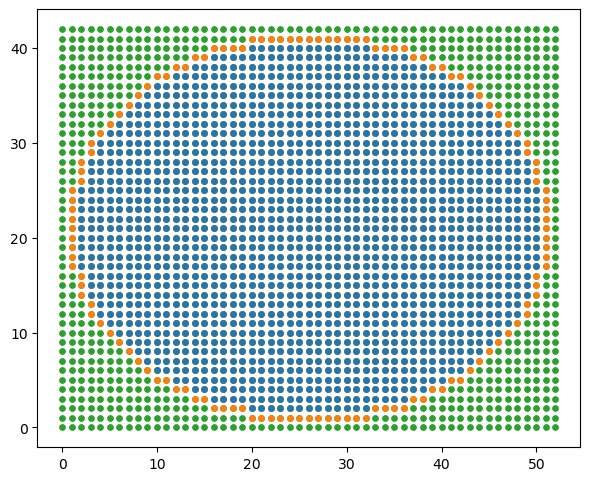

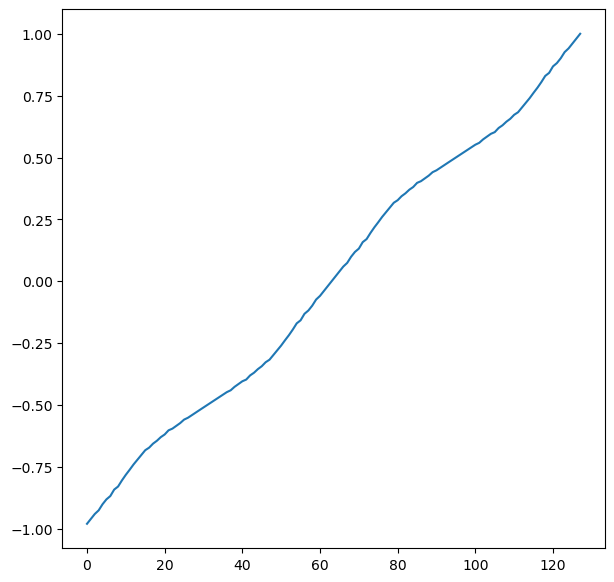

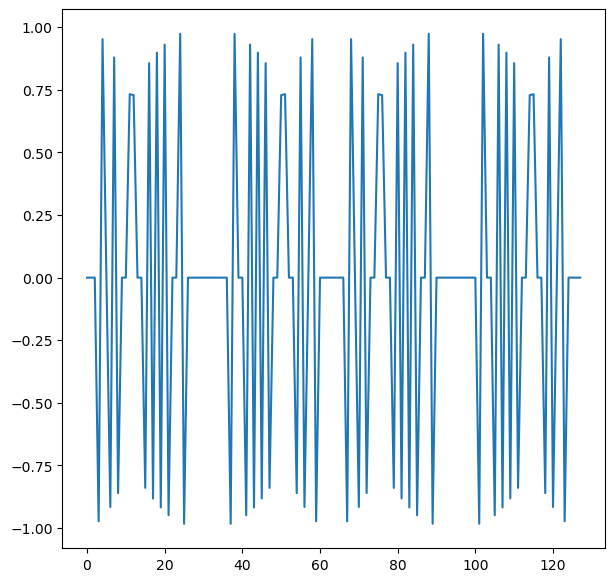

In [5]:
R1 = 25 #25
R2 = R1*57/71

Nx = int(round(2*R1) +3)
Ny = int(round(2*R2) +3)
def get_index(x,y,s):
    '''Returns the index of the orbital in x,y with spin s'''
    return int(Nx*Ny*s + Nx*y + x)

edge_points, normal_angles, in_or_out = generate_ellipse(R1,R2, npoints = 1000000)
edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])

indices_to_delete = []

#Delete edges
for point in zip(edge_points[0], edge_points[1]):
    #book index to delete
    indices_to_delete.append(get_index(point[0],point[1],1))


#Delete outside
amount_out = 0
def discriminant(x,y):
    r1 = R1
    r2 = R2
    return (x/r1)**2 + (y/r2)**2
X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
for x,y in zip(X.ravel(),Y.ravel()):
    if discriminant(x-Nx//2,y-Ny//2)>=1 and  get_index(x,y,1) not in indices_to_delete:
        indices_to_delete.append(get_index(x,y,0))
        indices_to_delete.append(get_index(x,y,1))
        amount_out += 1

inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)

inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:], s = 15)
ax.scatter(inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out], s = 15,zorder=-1)
ax.scatter(X,Y,zorder = -2,s = 15)

ax.set_aspect('equal')
fig.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(normal_angles/pi)
fig.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(in_or_out)
fig.show()

In [6]:
def generate_stadium(r,L,npoints=1000000):
    'Generates the set of points in the grid closest to an elipse with radii r1 and r2 and the angle of the normal vector.'
    theta = np.linspace(0, 2*pi, npoints, endpoint = False)
    sign_theta = 2*np.heaviside(theta-pi,0)-1
    cos_theta_plus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  + np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
    cos_theta_minus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  - np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
    
    cos_theta_prime = np.where(sign_theta*np.cos(theta)<=0, cos_theta_plus, cos_theta_minus)
    
    x = np.zeros(npoints)
    y = np.zeros(npoints)
    angles = np.where(theta<=pi, np.arccos(cos_theta_prime),-np.arccos(-cos_theta_prime))
    

    x = np.where(np.abs(theta)<=np.arctan(r/L),L+r*cos_theta_prime,x)
    x = np.where(np.abs(theta-pi/2)<=np.arctan(L/r),r/np.tan(theta),x)
    x = np.where(np.abs(theta-pi)<=np.arctan(r/L),-L-sign_theta*r*cos_theta_prime,x)
    x = np.where(np.abs(theta-3*pi/2)<=np.arctan(L/r),-r/np.tan(theta),x)
    x = np.where(np.abs(theta-2*pi)<=np.arctan(r/L),L-r*cos_theta_prime,x)
    
    y = np.where(np.abs(theta)<=np.arctan(r/L),r*(np.sqrt(1-cos_theta_prime**2)),y)
    y = np.where(np.abs(theta-pi/2)<=np.arctan(L/r),r*np.ones(npoints),y)
    y = np.where(np.abs(theta-pi)<=np.arctan(r/L),-sign_theta*r*(np.sqrt(1-cos_theta_prime**2)),y)
    y = np.where(np.abs(theta-3*pi/2)<=np.arctan(L/r),-r*np.ones(npoints),y)
    y = np.where(np.abs(theta-2*pi)<=np.arctan(r/L),-r*(np.sqrt(1-cos_theta_prime**2)),y)
    
    
    angles = np.where(np.abs(theta-pi/2)<np.arctan(L/r),pi/2*np.ones(npoints),angles)
    angles = np.where(np.abs(theta-3*pi/2)<np.arctan(L/r),-pi/2*np.ones(npoints),angles)

    
    z = np.exp(1j*angles)


    boundary_points, indices = np.unique(np.round(np.stack((x, y))), axis = 1, return_inverse=True)


    polar_angle = np.arctan2(boundary_points[1],boundary_points[0])
    boundary_points = boundary_points[:,np.argsort(polar_angle)]


    # Calculate the sum of elements in z that correspond to the same value in mask
    sums_real = np.bincount(indices, weights=z.real)
    sums_imag = np.bincount(indices, weights=z.imag)
    
    # Calculate the count of elements in b that correspond to the same value in mask
    counts = np.bincount(indices)
    
    # Calculate the average of elements in b that correspond to the same value in mask
    normal_angles = np.angle((sums_real + 1j*sums_imag)/counts)
    normal_angles = normal_angles[np.argsort(polar_angle)]

    second_displacements = np.roll(boundary_points,1,axis = 1)+np.roll(boundary_points,-1,axis = 1)-2*boundary_points #This is like a discrete second derivative.
    in_or_out = second_displacements[0]*np.cos(normal_angles) + second_displacements[1]*np.sin(normal_angles)

    #Get rid of points that are actually fully inside
    boundary_points = boundary_points[:,np.argwhere(in_or_out<=0.1).flatten()]
    normal_angles = normal_angles[np.argwhere(in_or_out<=0.1).flatten()]

    ##reapeat to get rid of points that are fully outside
    second_displacements = np.roll(boundary_points,1,axis = 1)+np.roll(boundary_points,-1,axis = 1)-2*boundary_points #This is like a discrete second derivative.
    in_or_out = second_displacements[0]*np.cos(normal_angles) + second_displacements[1]*np.sin(normal_angles) #Scalar product with the normal
    boundary_points = boundary_points[:,np.argwhere(in_or_out>=-1).flatten()]
    normal_angles = normal_angles[np.argwhere(in_or_out>=-1).flatten()]
    
    return boundary_points, normal_angles, in_or_out[np.argwhere(in_or_out>=-1).flatten()]

/tmp/ipykernel_12821/2055592561.py:5: RuntimeWarning: invalid value encountered in sqrt
  cos_theta_plus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  + np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
/tmp/ipykernel_12821/2055592561.py:6: RuntimeWarning: invalid value encountered in sqrt
  cos_theta_minus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  - np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
/tmp/ipykernel_12821/2055592561.py:16: RuntimeWarning: divide by zero encountered in divide
  x = np.where(np.abs(theta-pi/2)<=np.arctan(L/r),r/np.tan(theta),x)
/tmp/ipykernel_12821/2055592561.py:18: RuntimeWarning: divide by zero encountered in divide
  x = np.where(np.abs(theta-3*pi/2)<=np.arctan(L/r),-r/np.tan(theta),x)
/tmp/ipykernel_12821/3523223179.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_12821/3523223179.py:55: UserWarning: FigureCanvasAgg 

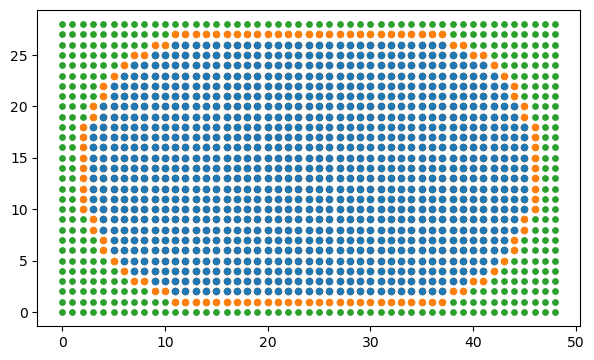

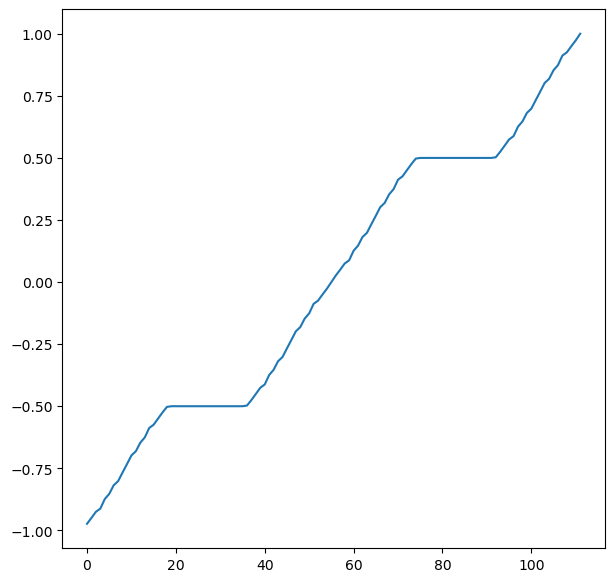

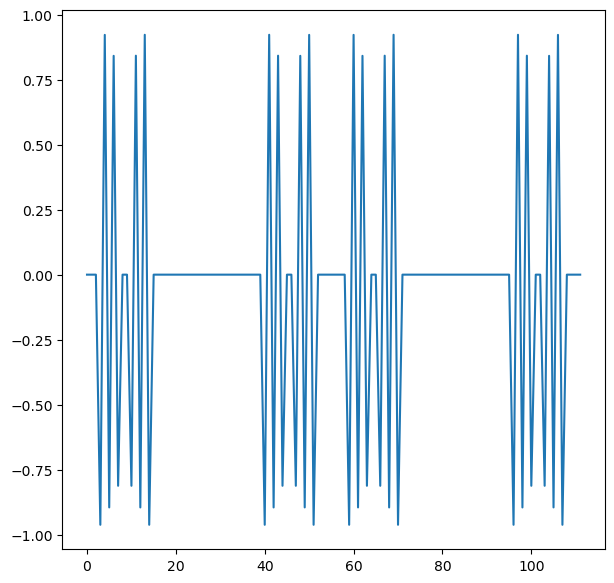

In [10]:
L = 10 #25
R = 13
Nx = 2*(L+R)+3
Ny = 2*R + 3
def get_index(x,y,s):
    '''Returns the index of the orbital in x,y with spin s'''
    return int(Nx*Ny*s + Nx*y + x)

edge_points, normal_angles, in_or_out = generate_stadium(r = Ny//2-1, L = Nx//2-Ny//2-1,npoints =1000000)
edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])

indices_to_delete = []

#Delete edges
for point in zip(edge_points[0], edge_points[1]):
    #book index to delete
    indices_to_delete.append(get_index(point[0],point[1],1))


#Delete outside
amount_out = 0
def discriminant(x,y):
    L = Nx//2-Ny//2-1
    r = Ny//2-1
    if x<-L:
        return ((x+L)/r)**2+(y/r)**2
    elif x>L:
        return ((x-L)/r)**2+(y/r)**2
    else:
        return (y/r)**2
X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
for x,y in zip(X.ravel(),Y.ravel()):
    if discriminant(x-Nx//2,y-Ny//2)>=1 and  get_index(x,y,1) not in indices_to_delete:
        indices_to_delete.append(get_index(x,y,0))
        indices_to_delete.append(get_index(x,y,1))
        amount_out += 1

inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)

inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:], s = 20)
ax.scatter(inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out], s = 20,zorder=-1)
ax.scatter(X,Y,zorder = -2,s = 15)
ax.set_aspect('equal')
fig.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(normal_angles/pi)
fig.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(in_or_out)
fig.show()